# Case Study 2 : Data Science in Financial Data

**Recommended Readings:** 
* [Quantopian Tutorials](https://www.quantopian.com/tutorials/) 
* Please register an account in [Quantopian online notebook system](https://www.quantopian.com/notebooks/).
* Upload this file into the system and start working on your idea.


**NOTE**
* Please download your code (notebook file as an ipynb file) and include it in your submission.


# Problem: pick a data science problem that you plan to solve using Stock Price Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data available and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [2]:
# In order to make money off of stocks, you want to diversify your portfolio. Essentially, this means you want to invest money
# in a number of unrelated stocks, in order to decrease the risk of losing money if one of your stocks loses value. Having 
# funds invested in a number of related stocks increases the chance that all of your stocks decrease in value at the same time.

# In this section of the project, we attempt to discover correlations in the DOW 30 stocks. We compare each possible pair of 
# stocks in an attempt to find correlated stocks. The DOW 30 set of stocks is seen as a good representative for the stock
# market as a whole. If we can find correlations in these stocks, it is possible to minimize variance using low or inverse
# correlatoins to improve relative return

# Data Collection/Processing: 

In [3]:
#gathering data

#imports
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize
from scipy.stats import norm 
import warnings
import seaborn as sb

#preliminary settings
warnings.filterwarnings("ignore")
np.random.seed(10)
s = 5   # number of stock subset
portfolios = 2000   # number of simulated portfoios
pers = 12   # number of periods in a year (monthly 12, weekly 52, trading daily 253)
test = 36   # periods in test set
rolling_corr = test

#pulls in DOW30 stock prices back to 2000 from CSV, drops columns with incomplete price history, for s stock subset
data = pd.read_csv('data_monthly.csv')
data.drop(['V', 'DOW'], axis=1, inplace=True)
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)

##############creates DJIA matrices############

#builds train and test subsets
DJIA_train = data.iloc[:-test]
DJIA_test = data.iloc[-test:]

#builds log returns
DJIA_log = np.log(DJIA_train/DJIA_train.shift(1))
DJIA_log = DJIA_log.iloc[1:]

#builds percent returns
DJIA_percent = DJIA_train / DJIA_train.shift(1) - 1
DJIA_percent = DJIA_percent.iloc[1:]

##############creates subset matrices############
stock_list = data.columns.tolist()
if s >= len(stock_list) : s = len(stock_list)
stock_selection = np.random.choice(stock_list, s, replace=False).tolist()
subset = data[stock_selection]

#builds train and test subsets
train = subset.iloc[:-test]
test = subset.iloc[-test:]

#builds log returns
log = np.log(train/train.shift(1))
log = log.iloc[1:]

#builds percent returns
percent = train / train.shift(1) - 1
percent = percent.iloc[1:]

# Data Exploration: Exploring the Dataset

**plot the weekly returns of a set of stocks of your choice** 


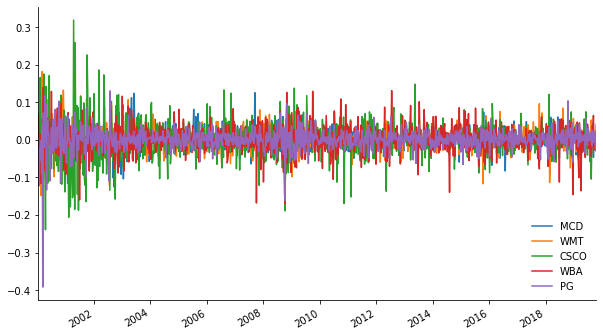

In [4]:
# plotting weekly returns of a set of stocks of our choice
#pulls in DOW30 stock prices back to 2000 from CSV, drops columns with incomplete price history, for s stock subset
WKLY_data = pd.read_csv('data_weekly.csv')
WKLY_data.drop(['V', 'DOW'], axis=1, inplace=True)
WKLY_data.Date = pd.to_datetime(WKLY_data.Date)
WKLY_data.set_index('Date', inplace=True)

WKLY_stock_list = WKLY_data.columns.tolist()
if s >= len(WKLY_stock_list) : s = len(WKLY_stock_list)
WKLY_stock_selection = np.random.choice(WKLY_stock_list, s, replace=False).tolist()
WKLY_subset = WKLY_data[WKLY_stock_selection]

WKLY_percent = WKLY_subset / WKLY_subset.shift(1) - 1
WKLY_percent = WKLY_percent.iloc[1:]
WKLY_percent.plot(figsize=(10,6))
plt.legend(loc = 'lower right', frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axes().xaxis.label.set_visible(False)
plt.savefig('WKLY_RET.png')

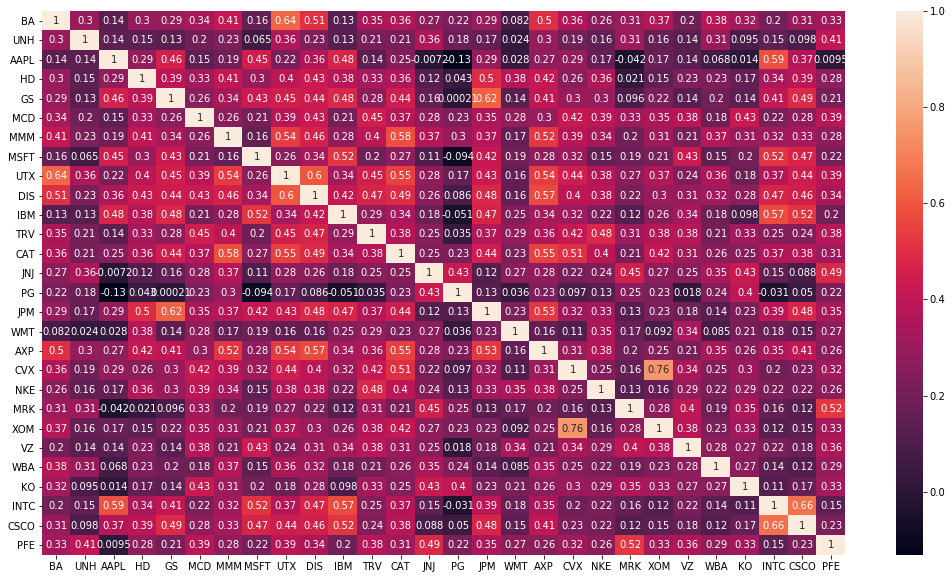

In [5]:
#build correlation heatmap
corrs = DJIA_percent.corr()
plt.figure(figsize=(18,10))
heat_map = sb.heatmap(corrs, annot = True, xticklabels = 1, yticklabels = 1)
plt.savefig('heatmap.png')
#plt.show()

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [6]:
# Using Markowitz Modern Portfolio Theory we attempt to construct an optimized portfolio along the efficient frontier
# Then we compare its performance

Write codes to implement the solution in python:

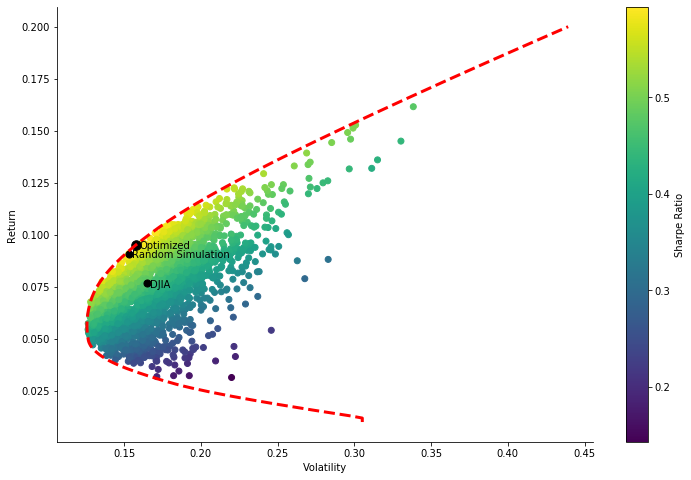

In [7]:
#plotting efficient frontier using random simulation

positions = len(log.columns)
weights = np.zeros((portfolios, positions))
returns = np.zeros(portfolios)
volatility = np.zeros(portfolios)
sharpe = np.zeros(portfolios)

for r in range(portfolios):
    
    wgt = np.array(np.random.random(positions))
    wgt = wgt / np.sum(wgt)
    weights[r,:] = wgt
    
    returns[r] = np.sum(log.mean() * wgt * pers)
    volatility[r] = np.sqrt(np.dot(wgt.T, np.dot(log.cov() * pers, wgt)))
    sharpe[r] = returns[r] / volatility[r]

equal = np.ones(positions)
equal = equal / positions

DJIA_ret = np.sum(log.mean() * equal * pers)
DJIA_vol = np.sqrt(np.dot(equal.T, np.dot(log.cov() * pers, equal)))
DJIA_sharpe = DJIA_ret / DJIA_vol

max_sharpe_ret = returns[sharpe.argmax()]
max_sharpe_vol = volatility[sharpe.argmax()]

def metrics(wgt) :
    wgt = np.array(wgt)
    ret = np.sum(log.mean() * wgt) * pers
    vol = np.sqrt(np.dot(wgt.T, np.dot(log.cov() * pers, wgt)))
    shp = ret / vol
    return np.array([ret, vol, shp])

def n_sharpe(wgt) :
    return metrics(wgt)[2] * -1

def check(wgt) :
    return np.sum(wgt) - 1

cons = ({'type' : 'eq', 'fun' : check})
bounds = [(0,1)] * positions
guess = [1/positions] * positions

optimized = minimize(n_sharpe, guess, method = 'SLSQP', bounds = bounds, constraints = cons)
best = metrics(optimized.x)

frontier_y = np.linspace(0.01, 0.2, 200)

def minimize_vol(wgt) :
    return metrics(wgt)[1]

frontier_x = []

#### This section takes forever to run
for f in frontier_y :
    cons = ({'type' : 'eq', 'fun' : check},
            {'type' : 'eq', 'fun' : lambda w: metrics(w)[0] - f}) 
    result = minimize(minimize_vol, guess, method = 'SLSQP', bounds = bounds, constraints = cons)
    frontier_x.append(result['fun'])
########################################
    
plt.figure(figsize=(12,8))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.scatter(volatility, returns, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
plt.scatter(best[1], best[0],c='black', s=90)
plt.annotate('Optimized', (best[1]+.002, best[0]-.002))
plt.scatter(max_sharpe_vol, max_sharpe_ret,c='black', s=50)
plt.annotate('Random Simulation', (max_sharpe_vol+.002, max_sharpe_ret-.002))
plt.scatter(DJIA_vol, DJIA_ret,c='black', s=50)
plt.annotate('DJIA', (DJIA_vol+.002, DJIA_ret-.002))
plt.savefig('frontier.png')
plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [8]:
# We tested the sample optimized portfolio vs the Dow Jones performance and found it outperformed on training data
# However, on test data the results did not carry forward

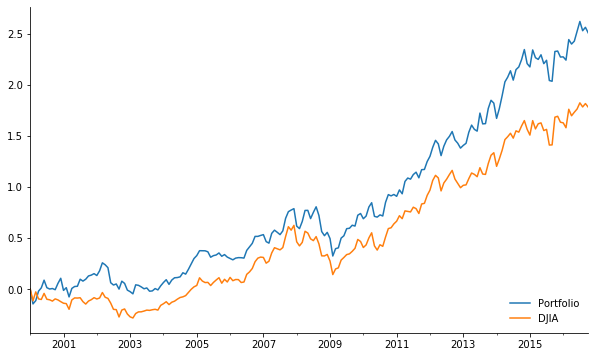

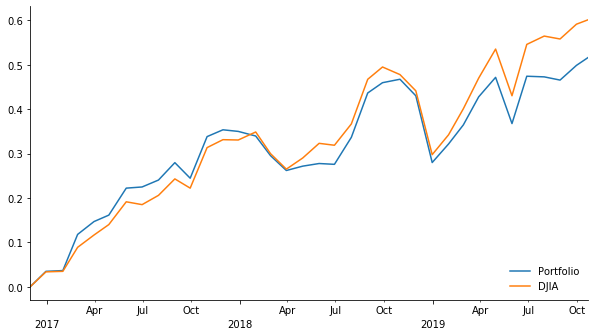

In [9]:
#plotting test
best_port = optimized.x
port_val = np.dot(test, best_port).tolist()
DJIA_val = np.dot(test, equal).tolist()
dates = np.array(test.index)

#establish training comparison
port_train = np.dot(train, best_port).tolist()
DJIA_train = np.dot(train, equal).tolist()
dates_train = np.array(train.index)

training = pd.DataFrame(dates_train, columns = ['Date'])
training['Portfolio'] = port_train
training['DJIA'] = DJIA_train
training.set_index('Date', inplace=True)
training = training / training.iloc[0] - 1
training.plot(figsize=(10,6))
plt.legend(loc = 'lower right', frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axes().xaxis.label.set_visible(False)
#plt.title('TRAINING')
plt.savefig('training.png')

testing = pd.DataFrame(dates, columns = ['Date'])
testing['Portfolio'] = port_val
testing['DJIA'] = DJIA_val
testing.set_index('Date', inplace=True)
testing = testing / testing.iloc[0] - 1
testing.plot(figsize=(10,6))
plt.legend(loc = 'lower right', frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axes().xaxis.label.set_visible(False)
plt.axes().xaxis.set_major_locator(mdates.YearLocator())
plt.axes().xaxis.set_minor_locator(mdates.MonthLocator((1,4,7,10)))
plt.axes().xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
plt.axes().xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
plt.setp(plt.axes().get_xticklabels(), rotation=0, ha="center")
#plt.title('TEST')
plt.savefig('testing.png')

In [10]:
# This was likely do to shifting correlations over time, which undermine the linear assumptions

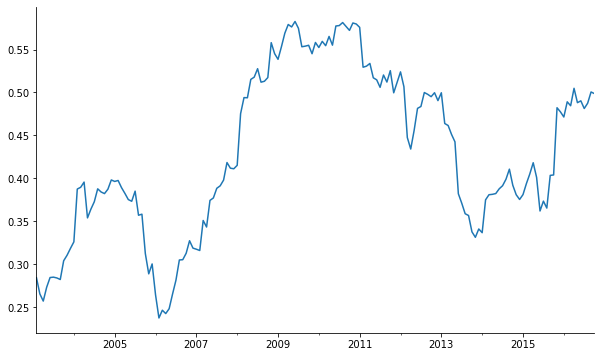

In [11]:
#plotting correlation over time
corr3=[]
for r in range(percent.shape[0]-rolling_corr) :
    c = percent.iloc[r:(r+rolling_corr)].corr().mean().mean()
    corr3.append(c)
corr_time = pd.DataFrame(train.index)
corr_time = corr_time.iloc[(rolling_corr+1):]
corr_time['Correlation'] = corr3
corr_time.set_index('Date', inplace=True)
corr_time.plot(figsize=(10,6))
plt.legend().set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axes().xaxis.label.set_visible(False)
plt.savefig('corr_mov.png')

In [12]:
# The distributions also did not follow a true Guassian distribution, with a higher peak and fatter tails

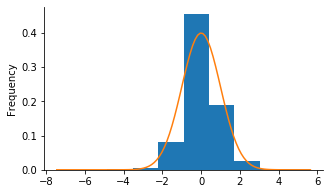

In [13]:
#plot return distribution vs gaussian
combined = []
norm_hist = percent.reset_index().drop('Date', axis=1)
for c in range(len(norm_hist.columns)) : 
    combined.append(norm_hist.iloc[:,c])
norm_hist = pd.concat(combined, ignore_index=True)
norm_hist = (norm_hist - norm_hist.mean()) / norm_hist.std()
plt.figure(figsize=(10,6))
norm_hist.plot(kind='hist', density=True, figsize=(5,3))
x = np.linspace(min(norm_hist), max(norm_hist), 100)
plt.plot(x, norm.pdf(x, 0, 1))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('returndist.png')


In [14]:
# Dispersion was also not constant over time

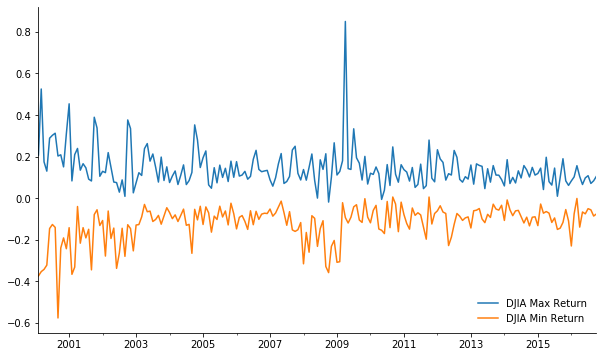

In [15]:
#plot dispersion over time
DJIA_percent['DJIA Max Return'] = DJIA_percent.max(axis=1)
DJIA_percent['DJIA Min Return'] = DJIA_percent.min(axis=1)
DJIA_percent[['DJIA Max Return','DJIA Min Return']].plot(figsize=(10,6))
plt.legend(loc = 'lower right', frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axes().xaxis.label.set_visible(False)
plt.savefig('dispersion.png')

In [16]:
# Overall, we found shifting linear relationships from data instationarity (shifting correlations, etc), 
# Undermined the portfolio's forward test performance


# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 2".
        
**Note: Each team only needs to submit one submission in Canvas**